In [117]:
from datetime import datetime
import os
import re

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn as sk
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
REMOTE_TRACKING_IP = os.getenv("REMOTE_IP", "localhost")
MLFLOW_TRACKING_URI = f"http://{REMOTE_TRACKING_IP}:5000"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

CREDIT_EXPERIMENT_NAME = "credit-score-train"
EXPERIMENT_NAME = "chosen-models-credit"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(CREDIT_EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/667472224209157606', creation_time=1712260345326, experiment_id='667472224209157606', last_update_time=1712260345326, lifecycle_stage='active', name='credit-score-train', tags={}>

In [3]:
def get_splits(data: pl.DataFrame):
    case_ids = data[["case_id"]].unique()
    case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.7)
    case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5)
    return case_ids_train, case_ids_valid, case_ids_test

In [10]:
def from_polars_to_pandas(data, case_ids: pl.DataFrame, cat_cols=None) -> pd.DataFrame:
    base = data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas()
    X = data.filter(pl.col("case_id").is_in(case_ids))[[x for x in data.columns if x not in ["case_id", "WEEK_NUM", "target"]]].to_pandas()
    y = data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    if cat_cols is None:
        cat_cols = list(X.select_dtypes("object").columns) + list(X.select_dtypes("bool").columns)
    
    X[cat_cols] = X[cat_cols].astype("category")
    return base, X, y

In [11]:
def load_data_splits(data_path: str):
    data = pl.read_parquet(data_path, use_pyarrow = True)
    case_ids_train, case_ids_valid, case_ids_test = get_splits(data)
    return (
        from_polars_to_pandas(data, case_ids_train),
        from_polars_to_pandas(data, case_ids_valid),
        from_polars_to_pandas(data, case_ids_test)
    )

In [119]:
(base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = load_data_splits("data/train_base.parquet")
cat_cols_base = list(X_train.select_dtypes("category").columns)

In [120]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

In [14]:
def train_lgb_model(params, train_data, valid_data) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                        callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
        mlflow.log_metric("auc", eval_result['eval']['auc'][-1])
        return bst, eval_result

In [15]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}


bst, eval_results = train_lgb_model(params, train_data, valid_data)

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783449
[100]	eval's auc: 0.803535
[150]	eval's auc: 0.812038
[200]	eval's auc: 0.817125
[250]	eval's auc: 0.820118
[300]	eval's auc: 0.822585
[350]	eval's auc: 0.824506
[400]	eval's auc: 0.825985
[450]	eval's auc: 0.827396
[500]	eval's auc: 0.828272
[550]	eval's auc: 0.829263
[600]	eval's auc: 0.829936
[650]	eval's auc: 0.830832
[700]	eval's auc: 0.831452
[750]	eval's auc: 0.831921
[800]	eval's auc: 0.832472
[850]	eval's auc: 0.832848
[900]	eval's auc: 0.833308
[950]	eval's auc: 0.833593
[1000]	eval's auc: 0.833799
Did not meet early stopping. Best iteration is:
[999]	eval's auc: 0.833802


In [16]:
eval_results['eval']['auc'][-1]

0.8337989849749787

In [121]:
ypred = bst.predict(X_test)

In [122]:
roc_auc_score(y_test.values, ypred)

0.8423493299022732

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


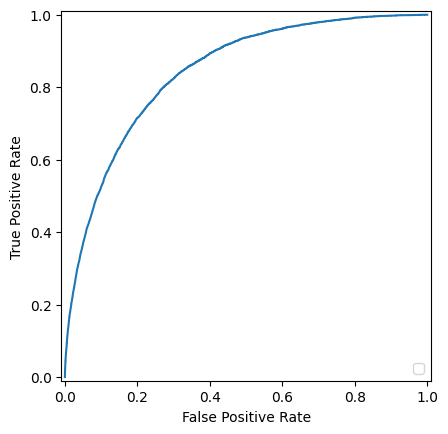

In [125]:
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test.values, ypred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [51]:
2 * roc_auc_score(y_test.values, ypred) - 1

0.6651304947989516

In [36]:
base_test['score'] = ypred
roc_by_week_test = base_test.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: roc_auc_score(x["target"], x["score"])).tolist()

In [53]:
pearsonr(roc_by_week_test, base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist())

PearsonRResult(statistic=-0.1646654898106778, pvalue=0.11675311435321464)

In [54]:
pearsonr(roc_by_week_test, base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist())

PearsonRResult(statistic=-0.056880097362124876, pvalue=0.5901962986100256)

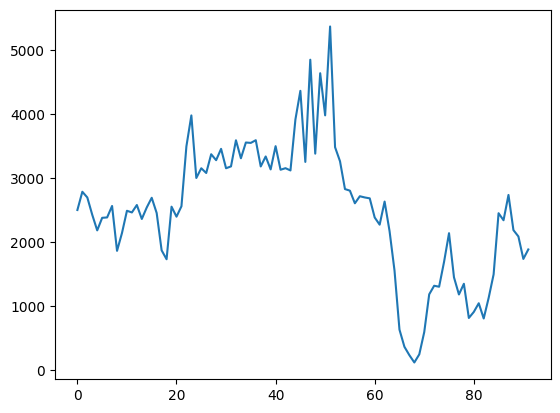

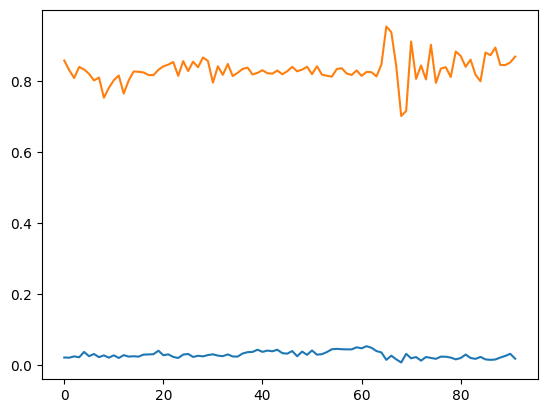

In [57]:
plt.plot(base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist()
)
plt.show()
plt.plot(base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist()
)
plt.plot(roc_by_week_test)
plt.show()

In [58]:
ypred = bst.predict(X_train)

In [59]:
roc_auc_score(y_train.values, ypred)

0.8482340525446741

In [60]:
base_train['score'] = ypred
roc_by_week_train = base_train.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: roc_auc_score(x["target"], x["score"])).tolist()

In [17]:
base['score'] = ypred
gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

0.13000668743092647

In [61]:
pearsonr(roc_by_week_train, base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist())

PearsonRResult(statistic=-0.33911312853054315, pvalue=0.0009438667669884408)

In [63]:
pearsonr(roc_by_week_train, base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist())

PearsonRResult(statistic=-0.1750018920969017, pvalue=0.09521426384954665)

In [64]:
pearsonr(base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist(), base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist())

PearsonRResult(statistic=0.38318487070577567, pvalue=0.00016318488610894515)

Judging by the train set, there is a pretty strong negative correlation between the default ratio and performance.  
But what does it tell us? How can it be worse to have larger class imbalance?  
Ensemble with cv splits on weeks could be helpful.  
Or some knn features with avg target on the nearest neighbors?  
Maybe TPR is the week part?  
Most likely, the model underestimates the probability of default in the weeks where it's higher

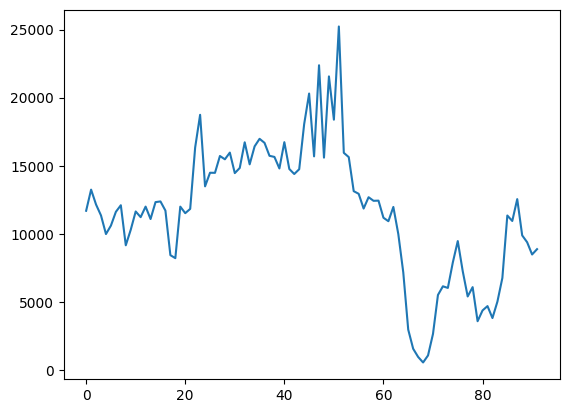

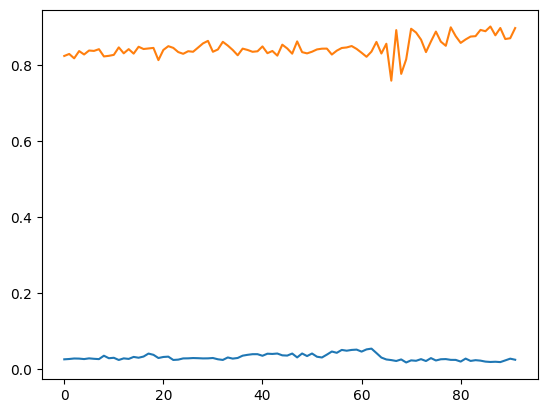

In [62]:
plt.plot(base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist()
)
plt.show()
plt.plot(base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist()
)
plt.plot(roc_by_week_train)
plt.show()

In [25]:
def get_lgbm_varimp(model, train_columns, max_vars=50):
    cv_varimp_df = pd.DataFrame([train_columns, model.feature_importance()]).T
    cv_varimp_df.columns = ['feature_name', 'varimp']
    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)
    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   
    return cv_varimp_df

In [27]:
imps = get_lgbm_varimp(bst, X_train.columns)

In [88]:
imps['feature_name'].tolist()

['price_1097A',
 'annuity_780A',
 'pmtnum_254L',
 'min_cancelreason_3545846M',
 'max_birth_259D',
 'mobilephncnt_593L',
 'pmtssum_45A',
 'days360_512L',
 'max_incometype_1044T',
 'cntpmts24_3658933L',
 'eir_270L',
 'validfrom_1069D',
 'inittransactionamount_650A',
 'max_sex_738L',
 'max_num_group1_1_3',
 'maxdpdinstldate_3546855D',
 'dateofbirth_337D',
 'max_pmtnum_8L',
 'mean_amount_4527230A',
 'applicationscnt_867L',
 'max_amount_4527230A',
 'lastrejectcommoditycat_161M',
 'numincomingpmts_3546848L',
 'pmtaverage_3A',
 'numinstlswithdpd10_728L',
 'pmtaverage_4527227A',
 'lastapprcommoditycat_1041M',
 'lastdelinqdate_224D',
 'days90_310L',
 'lastrejectdate_50D',
 'monthsannuity_845L',
 'max_familystate_447L',
 'avgdpdtolclosure24_3658938P',
 'last_amount_4527230A',
 'maxinstallast24m_3658928A',
 'datelastinstal40dpd_247D',
 'maxdbddpdtollast12m_3658940P',
 'pctinstlsallpaidlate1d_3546856L',
 'days180_256L',
 'maxdbddpdlast1m_3658939P',
 'days30_165L',
 'avglnamtstart24m_4525187A',
 'n

In [65]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    higher_better = True
    metric_name="gini_stability"
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [67]:
X_train = X_train[imps['feature_name']]
X_valid = X_valid[imps['feature_name']]
X_test = X_test[imps['feature_name']]
cat_cols_base = list(X_train.select_dtypes("category").columns)

In [68]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

In [69]:
bst_50, eval_results = train_lgb_model(params, train_data, valid_data)

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.775801
[100]	eval's auc: 0.795552
[150]	eval's auc: 0.803551
[200]	eval's auc: 0.807646
[250]	eval's auc: 0.810429
[300]	eval's auc: 0.812007
[350]	eval's auc: 0.813299
[400]	eval's auc: 0.814383
[450]	eval's auc: 0.815276
[500]	eval's auc: 0.815925
[550]	eval's auc: 0.816424
[600]	eval's auc: 0.816974
[650]	eval's auc: 0.817548
[700]	eval's auc: 0.818179
[750]	eval's auc: 0.818527
[800]	eval's auc: 0.819078
[850]	eval's auc: 0.819397
[900]	eval's auc: 0.819814
[950]	eval's auc: 0.820001
[1000]	eval's auc: 0.820191
Did not meet early stopping. Best iteration is:
[998]	eval's auc: 0.820196


In [70]:
eval_results['eval']['auc'][-1]

0.8201911664172478

In [71]:
ypred = bst_50.predict(X_test)

In [72]:
roc_auc_score(y_test.values, ypred)

0.818753148029813

In [73]:
2 * roc_auc_score(y_test.values, ypred) - 1

0.637506296059626

In [74]:
base_test['score'] = ypred
roc_by_week_test = base_test.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: roc_auc_score(x["target"], x["score"])).tolist()

In [75]:
pearsonr(roc_by_week_test, base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist())

PearsonRResult(statistic=-0.27532808776225953, pvalue=0.007900443536147357)

In [76]:
pearsonr(roc_by_week_test, base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist())

PearsonRResult(statistic=-0.15511678328942619, pvalue=0.13982640956439266)

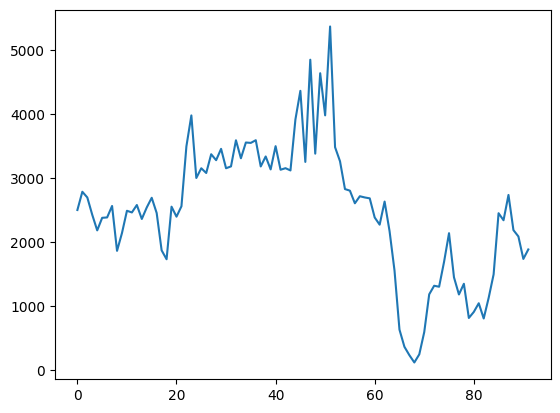

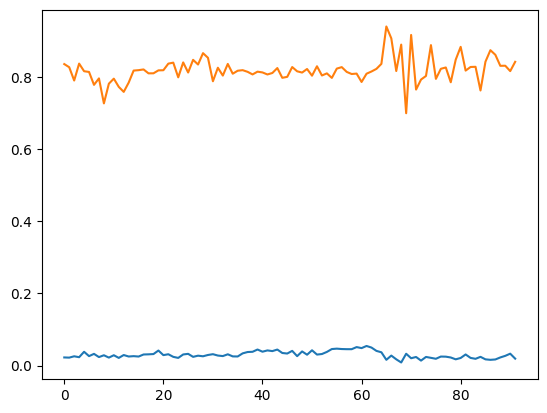

In [77]:
plt.plot(base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist()
)
plt.show()
plt.plot(base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist()
)
plt.plot(roc_by_week_test)
plt.show()

In [79]:
ypred = bst_50.predict(X_train)

In [80]:
roc_auc_score(y_train.values, ypred)

0.831755857564108

In [81]:
base_train['score'] = ypred
roc_by_week_train = base_train.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: roc_auc_score(x["target"], x["score"])).tolist()

In [84]:
base_train['score'] = ypred
gini_in_time = base_train.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

In [85]:
pearsonr(roc_by_week_train, base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist())

PearsonRResult(statistic=-0.2123367404699096, pvalue=0.042148544845142126)

In [86]:
pearsonr(roc_by_week_train, base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist())

PearsonRResult(statistic=0.04875180014445757, pvalue=0.644445710677392)

In [64]:
pearsonr(base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist(), base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist())

PearsonRResult(statistic=0.38318487070577567, pvalue=0.00016318488610894515)

Judging by the train set, there is a pretty strong negative correlation between the default ratio and performance.  
But what does it tell us? How can it be worse to have larger class imbalance?  
Ensemble with cv splits on weeks could be helpful.  
Or some knn features with avg target on the nearest neighbors?  
Maybe TPR is the week part?  
Most likely, the model underestimates the probability of default in the weeks where it's higher

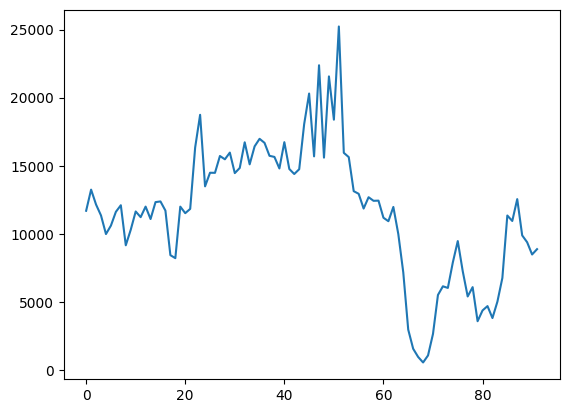

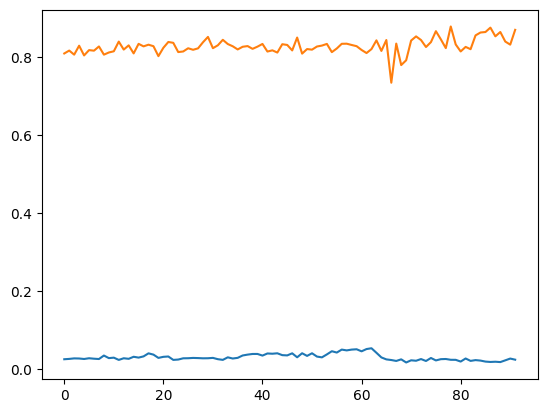

In [87]:
plt.plot(base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist()
)
plt.show()
plt.plot(base_train.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist()
)
plt.plot(roc_by_week_train)
plt.show()

# Conclusion:
It seems the performance gets worse with higher default rate, which may be key to the performance degradation
Maybe we can develop better features or improve the goal function - maybe focusing on TPR improvement could help.

Doing freq enc of cat features opens path to many new methods for feature eng and selection

In [72]:
np.unique(ypred, return_counts=True)

(array([0.01155312, 0.7784853 ]), array([295733,   9599]))

In [170]:
xdf = train_df[['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 
                 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 
                 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 
                 'inittransactionamount_650A','lastapprcredamount_781A', 'lastrejectcredamount_222A', 'maininc_215A', 'maxannuity_159A',
                 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A',
                 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'price_1097A', 
                 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 
                 'totinstallast1m_4525188A', 'description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 
                 'maritalst_893M', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtssum_45A', 'target']]

In [171]:
tr_df, te_df = train_test_split(xdf, stratify=xdf['target'], test_size=0.2)
tr_df, va_df = train_test_split(tr_df, stratify=tr_df['target'], test_size=0.1)
trd = lgb.Dataset(tr_df[[x for x in tr_df.columns if x != 'target']], 
                  label=tr_df['target'], 
                  categorical_feature=['description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 'maritalst_893M']
                 )
ted = lgb.Dataset(te_df[[x for x in te_df.columns if x != 'target']], 
                  label=te_df['target'], 
                  categorical_feature=['description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 'maritalst_893M']
                 )
vad = lgb.Dataset(va_df[[x for x in va_df.columns if x != 'target']], 
                  label=va_df['target'], 
                  categorical_feature=['description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 'maritalst_893M']
                 )

In [172]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

chck = lgb.train(params, trd, valid_sets=vad, callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)])

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.693382
[100]	valid_0's auc: 0.707502
[150]	valid_0's auc: 0.713174
[200]	valid_0's auc: 0.716931
[250]	valid_0's auc: 0.720201
[300]	valid_0's auc: 0.72282
[350]	valid_0's auc: 0.724252
[400]	valid_0's auc: 0.726079
[450]	valid_0's auc: 0.727473
[500]	valid_0's auc: 0.728876
[550]	valid_0's auc: 0.729794
[600]	valid_0's auc: 0.730611
[650]	valid_0's auc: 0.731657
[700]	valid_0's auc: 0.732023
[750]	valid_0's auc: 0.732569
Early stopping, best iteration is:
[764]	valid_0's auc: 0.73284


In [173]:
ypred = chck.predict(te_df[[x for x in te_df.columns if x != 'target']])

In [174]:
roc_auc_score(te_df['target'], ypred)

0.735416318264719

In [86]:
tr_df.iloc[:, :-1]

,dateofbirth_337D,education_1103M,credamount_770A,annuity_780A,price_1097A
1462243,-26397.0,a55475b1,70000.0,7953.4000,0.0
312003,-17372.0,a55475b1,27278.0,2273.2000,27278.0
978938,-15562.0,a55475b1,28898.0,2408.2000,38898.0
933185,-14129.0,a55475b1,27452.4,2287.8000,27452.4
631232,-24263.0,6b2ae0fa,5980.0,1184.6000,5980.0
...,...,...,...,...,...
929628,-17691.0,a55475b1,27650.0,1536.2001,27650.0
265955,NaN,a55475b1,17978.0,1665.8000,17978.0
38092,NaN,a55475b1,30000.0,3536.2000,NaN
1376314,-24366.0,6b2ae0fa,60000.0,11766.2000,0.0


In [84]:
from sklearn.linear_model import SGDClassifier

In [114]:
sgd = SGDClassifier(max_iter=1000, loss="log_loss", class_weight="balanced")

In [119]:
sgd.fit(tr_df[[x for x in tr_df.columns if x not in ['description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 
                 'maritalst_893M', 'target']]].fillna(0), tr_df['target'])

SGDClassifier(class_weight='balanced', loss='log_loss')

In [120]:
pred = sgd.predict(te_df[[x for x in tr_df.columns if x not in ['description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 
                 'maritalst_893M', 'target']]].fillna(0))

In [121]:
roc_auc_score(te_df['target'], pred)

0.5231452060506899

In [146]:
f1_score(te_df['target'], ypred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [94]:
base_train['weight'] = base_train['target'].apply(lambda x: 10 if x == 1 else 1)
base_valid['weight'] = base_valid['target'].apply(lambda x: 10 if x == 1 else 1)
base_test['weight'] = base_test['target'].apply(lambda x: 10 if x == 1 else 1)

In [105]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base, weight=base_train['weight'])
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base, weight=base_valid['weight'])
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base, weight=base_test['weight'])

In [106]:
bst_50_bal, eval_results = train_lgb_model(params, train_data, valid_data)

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.7726
[100]	eval's auc: 0.794422
[150]	eval's auc: 0.802721
[200]	eval's auc: 0.807212
[250]	eval's auc: 0.810162
[300]	eval's auc: 0.812133
[350]	eval's auc: 0.813498
[400]	eval's auc: 0.814689
[450]	eval's auc: 0.815725
[500]	eval's auc: 0.816595
[550]	eval's auc: 0.817298
[600]	eval's auc: 0.818023
[650]	eval's auc: 0.818407
[700]	eval's auc: 0.819026
[750]	eval's auc: 0.819502
[800]	eval's auc: 0.820006
[850]	eval's auc: 0.820242
[900]	eval's auc: 0.820624
[950]	eval's auc: 0.820891
[1000]	eval's auc: 0.821178
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.821178


In [107]:
eval_results['eval']['auc'][-1]

0.8211783443105655

In [108]:
ypred = bst_50_bal.predict(X_test)

In [116]:
roc_auc_score(y_test.values, ypred)

0.8191716237831225

In [110]:
2 * roc_auc_score(y_test.values, ypred) - 1

0.6383432475662449

In [111]:
base_test['score'] = ypred
roc_by_week_test = base_test.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: roc_auc_score(x["target"], x["score"])).tolist()

In [112]:
pearsonr(roc_by_week_test, base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist())

PearsonRResult(statistic=-0.2877253022498516, pvalue=0.005417521361340582)

In [113]:
pearsonr(roc_by_week_test, base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist())

PearsonRResult(statistic=-0.16388941080906338, pvalue=0.11851096090434428)

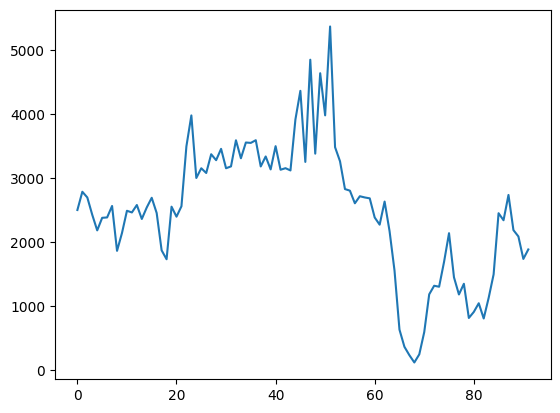

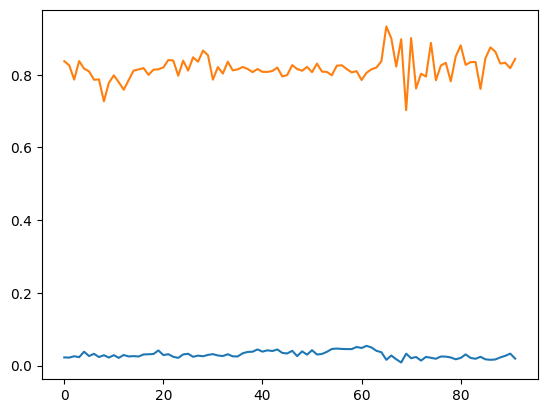

In [114]:
plt.plot(base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].count().tolist()
)
plt.show()
plt.plot(base_test.sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")["target"].mean().tolist()
)
plt.plot(roc_by_week_test)
plt.show()